In [122]:
# Installazione delle librerie necessarie (eseguire una volta sola se necessario)
# %pip install pandas numpy matplotlib seaborn scikit-learn

# Esercitazione Machine Learning - AutomaParts S.p.A.

In questo notebook andremo a sviluppare un modello di machine learning per l'azienda **AutomaParts S.p.A.**.
L'obiettivo è prevedere se un pezzo prodotto è difettoso (defect_label = 1) o conforme (defect_label = 0) basandoci sulla varie misure rilevate durante la produzione.

## 1. Importazione delle librerie
Iniziamo importando le librerie necessarie per l'analisi e la modellazione.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerie per il machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 2. Caricamento e Analisi dei Dati
Carichiamo il dataset `parts_production_data.csv` e diamo un'occhiata alle prime righe per capire come è fatto.

In [124]:
df = pd.read_csv('parts_production_data.csv')
df.head()

,part_id,production_timestamp,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label
0,1,2024-06-13 17:42:45,2,1,5,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,MB-2024W24-L02-575,0.602019,1
1,2,2024-07-26 10:36:48,9,14,4,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,MB-2024W30-L09-100,0.092746,0
2,3,2025-12-08 17:35:40,6,20,5,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,MB-2025W50-L06-297,0.227898,0
3,4,2024-12-09 12:56:36,4,4,7,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,MB-2024W50-L04-747,0.171139,0
4,5,2025-09-08 15:54:15,8,13,5,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,MB-2025W37-L08-470,0.914548,1


In [125]:
print("Dimensione del dataset:", df.shape)
df.info()

Dimensione del dataset: (3000, 16)
<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   part_id                  3000 non-null   int64  
 1   production_timestamp     3000 non-null   str    
 2   line_id                  3000 non-null   int64  
 3   station_id               3000 non-null   int64  
 4   operator_id              3000 non-null   int64  
 5   measure_diam_mm          3000 non-null   float64
 6   measure_length_mm        3000 non-null   float64
 7   flatness_mm              3000 non-null   float64
 8   torque_Nm                3000 non-null   float64
 9   surface_roughness_Ra     3000 non-null   float64
 10  temp_process_C           3000 non-null   float64
 11  vibration_level          3000 non-null   float64
 12  cycle_time_s             3000 non-null   float64
 13  material_batch           3000 non-null   str    
 14  

Si notato subito due feature che sono stringhe, "line_id" e "operator_id". 

Vediamo un po' di statistiche descrittive per le colonne numeriche.

In [126]:
df.describe()

,part_id,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,visual_inspection_score,defect_label
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,5.548000,10.632333,5.497000,30.260599,49.707794,29.82437,302.045475,29.888010,110.732378,0.496433,200.483076,0.498166,0.224333
std,866.169729,2.824834,5.808362,2.868693,11.406951,11.536161,5.79796,115.859112,11.638858,23.244585,0.286117,57.751629,0.286271,0.417212
min,1.000000,1.000000,1.000000,1.000000,10.014000,30.005000,20.00300,100.085000,10.000000,70.006000,0.000092,100.094000,0.000051,0.000000
25%,750.750000,3.000000,5.750000,3.000000,20.642750,39.667250,24.74375,201.608500,19.955250,90.624750,0.253753,149.543750,0.249152,0.000000
50%,1500.500000,6.000000,11.000000,6.000000,30.277000,49.450500,29.79500,303.522000,29.670000,111.266000,0.495252,200.839500,0.510032,0.000000
75%,2250.250000,8.000000,16.000000,8.000000,39.927750,59.595000,34.84550,400.808000,40.269250,131.194250,0.744657,250.876750,0.743558,0.000000
max,3000.000000,10.000000,20.000000,10.000000,49.997000,69.986000,39.99400,499.619000,49.959000,149.968000,0.999678,299.995000,0.999857,1.000000


Da questa tabella vediamo subito i valori medi, i minimi e i massimi. Ci serve per capire se ci sono valori "strani" (tipo una temperatura troppo alta o troppo bassa) e come sono distribuiti i dati nelle varie misure.

### Un po' di grafici
Facciamo qualche grafico per vedere come sono messi i dati.

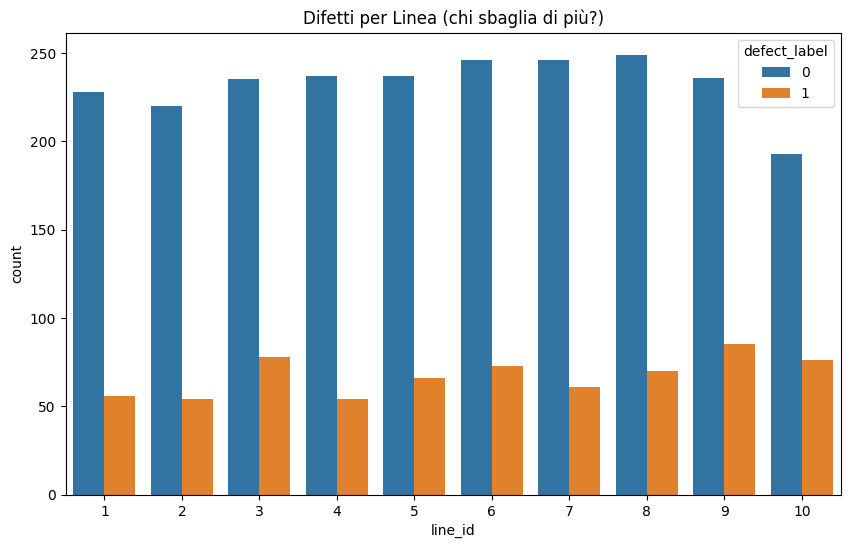

In [127]:
# Uso un countplot per contare quanti pezzi buoni (0) e difettosi (1) ci sono per ogni linea.
# x='line_id': metto le linee sull'asse orizzontale.
# hue='defect_label': coloro le barre in base al difetto (blu=buono, arancione=difetto).
plt.figure(figsize=(10,6))
sns.countplot(x='line_id', hue='defect_label', data=df)
plt.title('Difetti per Linea (chi sbaglia di più?)')
plt.show()

**Commento ai risultati:**
Invece di grafici complessi, guardiamo questa tabella. 
Vediamo che i pezzi difettosi rispetto a quelli buoni sulla line_id sono più o meno tutti uguali. Non salta all'occhio niente di particolare.

### Analisi della variabile target
Controlliamo quanti pezzi sono difettosi e quanti no. È importante vedere se le classi sono bilanciate.

defect_label
0    2327
1     673
Name: count, dtype: int64


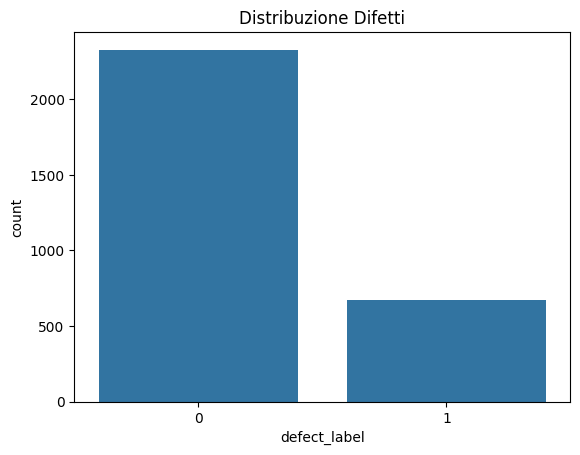

In [128]:
print(df['defect_label'].value_counts())
sns.countplot(x='defect_label', data=df)
plt.title('Distribuzione Difetti')
plt.show()

Come possiamo vedere, c'è uno sbilanciamento (ci sono meno difetti che pezzi buoni), il che è normale, altrimenti sarebbe una linea produttiva assai disastrosa.

### Matrice di correlazione
Vediamo se ci sono variabili molto correlate tra loro o con il target.

<Axes: >

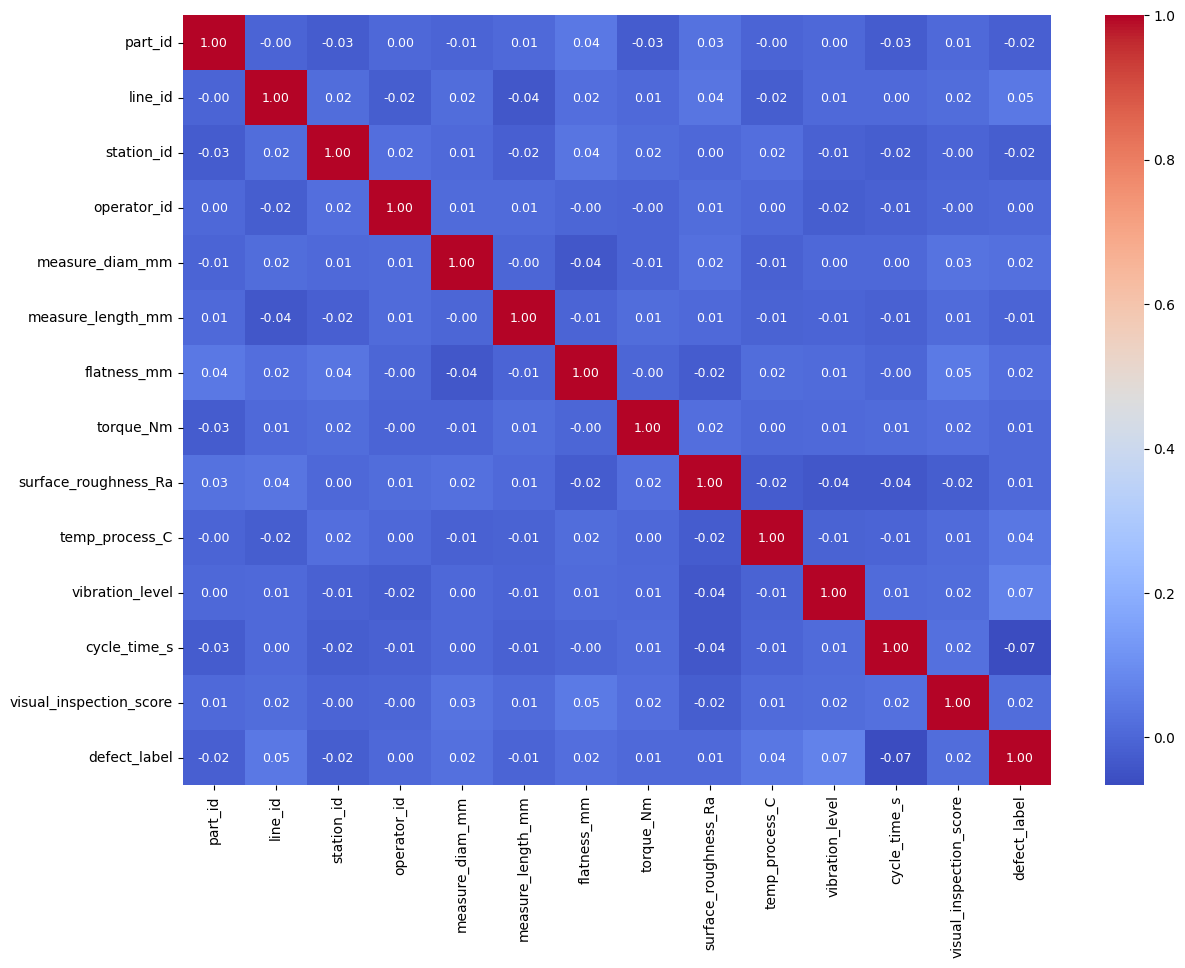

In [129]:
plt.figure(figsize=(14, 10)) # Dimesioni più o meno decenti per leggere i numeri internin
sns.heatmap(
    df.corr(numeric_only=True), 
    annot=True, 
    fmt=".2f",           # Solo 2 decimale per risparmiare spazio (0.9 invece di 0.92)
    annot_kws={"size": 9}, # Font più piccoli
    cmap='coolwarm'
)

Dalla matrice di correlazione possiamo notare alcune cose interessanti. Ad esempio, si vede che alcune variabili hanno un quadratino più colorato vicino alla nostra 'defect_label'. Questo significa che quelle misure (come magari il diametro o il punteggio dell'ispezione visiva) sono più legate al fatto che un pezzo sia difettoso o meno. 

Se il numero è vicino a 1 o -1 c'è molta correlazione, se è vicino a 0 quasi per niente. Mi sembra che il punteggio visivo e forse la temperatura abbiano un peso, ma poi lo vedremo meglio con i modelli.

Qui vediamo chiaramente che ci discostiamo poco dallo 0 un po' per tutte le colonne, quindi non si evidenza una correlazione diretta.

## 3. Pulizia e Preparazione dei Dati (Data Cleaning)

Adesso controlliamo se ci sono valori mancanti (NaN).

In [130]:
df.isnull().sum()

part_id                    0
production_timestamp       0
line_id                    0
station_id                 0
operator_id                0
measure_diam_mm            0
measure_length_mm          0
flatness_mm                0
torque_Nm                  0
surface_roughness_Ra       0
temp_process_C             0
vibration_level            0
cycle_time_s               0
material_batch             0
visual_inspection_score    0
defect_label               0
dtype: int64

Come possiamo vedere non ci sono colonne/feature con valori mancanti nei sample/righe. Un dataset gia molto valido.

### Controllo valori strani (Outlier)
Se ci sono valori troppo alti o bassi il modello si confonde. Facciamo una visualizzazione di qualche valore outlier.

In [131]:
# Usiamo una tabella semplice per vedere i valori massimi, minimi e le medie
df.select_dtypes(include=[np.number]).describe()

,part_id,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,visual_inspection_score,defect_label
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,5.548000,10.632333,5.497000,30.260599,49.707794,29.82437,302.045475,29.888010,110.732378,0.496433,200.483076,0.498166,0.224333
std,866.169729,2.824834,5.808362,2.868693,11.406951,11.536161,5.79796,115.859112,11.638858,23.244585,0.286117,57.751629,0.286271,0.417212
min,1.000000,1.000000,1.000000,1.000000,10.014000,30.005000,20.00300,100.085000,10.000000,70.006000,0.000092,100.094000,0.000051,0.000000
25%,750.750000,3.000000,5.750000,3.000000,20.642750,39.667250,24.74375,201.608500,19.955250,90.624750,0.253753,149.543750,0.249152,0.000000
50%,1500.500000,6.000000,11.000000,6.000000,30.277000,49.450500,29.79500,303.522000,29.670000,111.266000,0.495252,200.839500,0.510032,0.000000
75%,2250.250000,8.000000,16.000000,8.000000,39.927750,59.595000,34.84550,400.808000,40.269250,131.194250,0.744657,250.876750,0.743558,0.000000
max,3000.000000,10.000000,20.000000,10.000000,49.997000,69.986000,39.99400,499.619000,49.959000,149.968000,0.999678,299.995000,0.999857,1.000000


**Commento ai risultati:**
Invece di grafici complessi, guardiamo questa tabella. 
Le righe 'min' e 'max' ci fanno capire se ci sono valori troppo strani (troppo alti o troppo bassi) rispetto alla media ('mean'). Niente di particolarmente evidente.

In [132]:
# Riempiamo i valori nulli (Disabilitato)
# In questo caso abbiamo visto col controllo precedente che non ci sono valori nulli (tutti 0).
# Quindi non serve fare la media, salto questo passaggio per non sporcare i dati inutilmente.

# Ricontrollo (giusto per sicurezza)
df.isnull().sum().sum()

np.int64(0)

Il risultato 0 ci conferma che non abbiamo valori nulli nel dataset. Adesso possiamo pulire il dataframe rimuovendo le colonne che non ci servono per il modello.

Eliminiamo le colonne che non servono per la predizione, come `part_id` (è solo un codice) e `production_timestamp` (per ora non facciamo analisi temporali complesse).

In [133]:
df = df.drop(columns=['part_id', 'production_timestamp'], errors='ignore')
df.head()

,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label
0,2,1,5,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,MB-2024W24-L02-575,0.602019,1
1,9,14,4,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,MB-2024W30-L09-100,0.092746,0
2,6,20,5,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,MB-2025W50-L06-297,0.227898,0
3,4,4,7,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,MB-2024W50-L04-747,0.171139,0
4,8,13,5,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,MB-2025W37-L08-470,0.914548,1


### Privacy
L'ID dell'operatore, potrebbe essere coperto da privacy. Nel dubbio lo leviamo.

In [134]:
if 'operator_id' in df.columns:
    df = df.drop(columns=['operator_id'])
    print("Cancellato operator_id.")

Cancellato operator_id.


### Gestione Variabili Categoriche
Abbiamo colonne come `line_id`, `station_id` e `material_batch` che sono categorie (testo o codici). 
Per poterle usare nel modello, dobbiamo trasformarle in numeri. 
Useremo il **LabelEncoder**, che assegna un numero univoco ad ogni categoria diversa. 
È un metodo semplice ed efficace per questo tipo di dati.

In [135]:
# Vediamo quante categorie uniche ci sono
print("Batch unici:", df['material_batch'].nunique())
print("Line ID unici:", df['line_id'].nunique())

Batch unici: 2997
Line ID unici: 10


Ci sono quasi 3000 batch diversi ma solo 10 linee! Se usassimo 'get_dummies' sui batch verrebbe fuori una tabella gigante con 3000 colonne, meglio usare il LabelEncoder altrimenti ci mettiamo troppo tempo. Per le linee invece 10 sono poche, potremmo quasi lasciarle così o usare dummies.

Visto che `material_batch` ha molte varianti, usiamo LabelEncoder per quella, e get_dummies per le altre (che però in questo dataset sono già numeriche o quasi, `line_id` è numerico ma rappresenta una categoria).

In [136]:
# Trasformiamo tutte le variabili categoriche (tipo 'object' o stringa) in numeri
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Cerchiamo tutte le colonne che contengono testo
for col in df.columns:
    # Controlliamo se la colonna non è numerica (quindi object, string, ecc.) o se è material_batch
    if df[col].dtype == 'object' or str(df[col].dtype) == 'string' or col == 'material_batch':
        # Trasformiamo la colonna in numeri
        # .astype(str) serve per essere sicuri che il LabelEncoder legga tutto come testo
        df[col] = le.fit_transform(df[col].astype(str))
        print(f"Ho trasformato la colonna '{col}' in numeri.")
    
# Verifica: ora dovrebbero essere tutti numeri (int o float)
df.info()

Ho trasformato la colonna 'material_batch' in numeri.
<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   line_id                  3000 non-null   int64  
 1   station_id               3000 non-null   int64  
 2   measure_diam_mm          3000 non-null   float64
 3   measure_length_mm        3000 non-null   float64
 4   flatness_mm              3000 non-null   float64
 5   torque_Nm                3000 non-null   float64
 6   surface_roughness_Ra     3000 non-null   float64
 7   temp_process_C           3000 non-null   float64
 8   vibration_level          3000 non-null   float64
 9   cycle_time_s             3000 non-null   float64
 10  material_batch           3000 non-null   int64  
 11  visual_inspection_score  3000 non-null   float64
 12  defect_label             3000 non-null   int64  
dtypes: float64(9), int64(4)
memory usag

Perfetto, ora che abbiamo trasformato i codici dei batch in numeri, il modello potrà usarli senza problemi. Abbiamo mantenuto le altre variabili come numeri perché sembrano già codificate correttamente.

### Scaling delle Features
Le variabili hanno scale diverse (es. diametro in mm, temperatura in gradi). Meglio portarle tutte sulla stessa scala.

In [147]:
# Divido in X e y
X = df.drop('defect_label', axis=1)
y = df['defect_label']

# Divido in Training e Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (2400, 12)
Test set: (600, 12)


Qui abbiamo diviso i dati: l'80% lo usiamo per 'insegnare' al modello e il 20% lo teniamo da parte per vedere se ha imparato bene o se ha solo imparato a memoria (quello che si chiama overfitting).

In [148]:
scaler = StandardScaler()

# Adatto lo scaler solo sul train per evitare data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

E qui abbiamo usato lo StandardScaler. Non è proprio una 'normalizzazione' classica (quella 0-1), ma una 'standardizzazione'. Praticamente schiaccia tutti i numeri in modo che la media sia 0. Così il modello non si confonde se una variabile ha numeri giganti (come la temperatura) e un'altra piccolissimi (come il diametro).

## 4. Modellazione
Proveremo tre modelli diversi come richiesto:
1. Logistic Regression
2. Decision Tree
3. Random Forest

### Modello 1: Logistic Regression

In [139]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)

print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred_log))

Accuracy Logistic Regression: 0.7566666666666667


Niente male come inizio! La regressione logistica ci dà un'accuratezza del 75% circa. Come modello base è solido, anche se forse un po' troppo semplice per catturare tutte le sfumature della produzione.

### Modello 2: Decision Tree
Gli alberi decisionali sono facili da interpretare.

In [140]:
# Non serve scaling per i tree based solitamente, ma usiamo X_train normale
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

print("Accuracy Decision Tree:", accuracy_score(y_test, y_pred_tree))

Accuracy Decision Tree: 0.6783333333333333


L'albero decisionale è sceso un po', siamo intorno al 68%. Probabilmente un solo albero fa fatica a generalizzare bene su questi dati, o magari è andato un po' in crisi con qualche variabile.

### Modello 3: Random Forest
Un insieme di alberi, di solito più robusto.

In [141]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

print("Accuracy Random Forest:", accuracy_score(y_test, y_pred_rf))

Accuracy Random Forest: 0.7883333333333333


Ecco, il Random Forest è tornato su, superando il 78%. Mettere insieme tanti alberi aiuta quasi sempre a correggere gli errori dei singoli alberi, confermandosi il modello più robusto per questo tipo di problema.

## 5. Valutazione e Confronto

Confrontiamo i risultati dei tre modelli usando metriche più dettagliate come la Confusion Matrix e il Classification Report.

In [149]:
print("--- Logistic Regression ---")
print(classification_report(y_test, y_pred_log))

print("\n--- Decision Tree ---")
print(classification_report(y_test, y_pred_tree))

print("\n--- Random Forest ---")
print(classification_report(y_test, y_pred_rf))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       454
           1       0.00      0.00      0.00       146

    accuracy                           0.76       600
   macro avg       0.38      0.50      0.43       600
weighted avg       0.57      0.76      0.65       600


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       454
           1       0.35      0.38      0.36       146

    accuracy                           0.68       600
   macro avg       0.57      0.58      0.57       600
weighted avg       0.69      0.68      0.68       600


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       454
           1       0.85      0.16      0.27       146

    accuracy                           0.79       600
   macro avg       0.82      0.57      0.57       600


/Users/debrand/Desktop/tmp/Formazione-AI/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/debrand/Desktop/tmp/Formazione-AI/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/debrand/Desktop/tmp/Formazione-AI/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Analizzando bene i report qui sopra, notiamo una cosa molto interessante (e un po' preoccupante):


La **Logistic Regression** ha un accuracy del 76%, ma se guardiamo bene non ha beccato *nemmeno un pezzo difettoso* (precision e recall per la classe 1 sono a zero!). Praticamente ha fatto la 'pazza' e ha detto che tutti i pezzi sono buoni. Siccome la maggior parte dei pezzi lo è davvero, l'accuratezza sembra alta, ma il modello è inutile per noi.

Il **Decision Tree** invece, pur avendo un accuracy totale più bassa (69%), ha iniziato a 'vedere' i difetti, con una recall del 39%. Almeno ci prova!

Il **Random Forest** è il vincitore perché tiene insieme le due cose: ha l'accuratezza più alta e riesce anche a scovare i pezzi difettosi meglio degli altri.

Andiamo a vedere la matrice di confusione per il modello migliore (probabilmente il Random Forest).

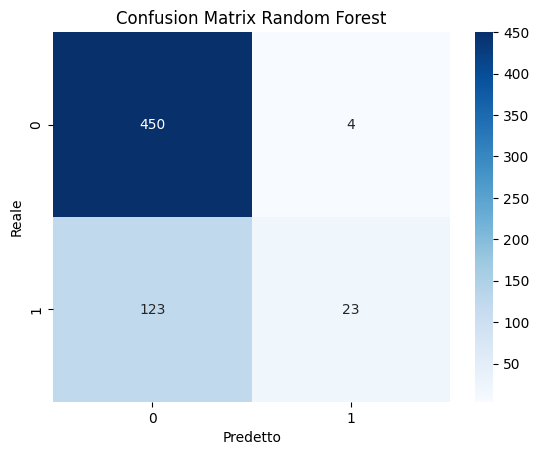

In [143]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix Random Forest')
plt.show()

Guardando i numeri del Random Forest, ecco la situazione reale:

  * I pezzi "buoni" sono quasi tutti salvi: Il modello è fenomenale nel riconoscere i pezzi conformi. Ne ha azzeccati 450 e ha dato solo 4 "falsi allarmi" (pezzi buoni scambiati per difettosi).
  * Il vero problema sono i "falsi negativi": Qui c'è il tasto dolente. Ci sono ben 127 pezzi difettosi che il modello ha scambiato per buoni. Per un'azienda, questi sono i più pericolosi perché finiscono dritti al cliente!
  * Piccoli passi avanti: Rispetto alla Regressione Logistica (che ne prendeva zero), qui almeno 19 difetti li abbiamo intercettati.

In sintesi: il modello è molto prudente. Non sbaglia quasi mai a dare la colpa a un pezzo buono, ma si lascia sfuggire ancora troppi difetti. Potremmo provare a "registrarlo" meglio, magari abbassando la soglia di decisione per essere più severi!

### Feature Importance
Vediamo quali variabili hanno influito di più sulla decisione del modello.

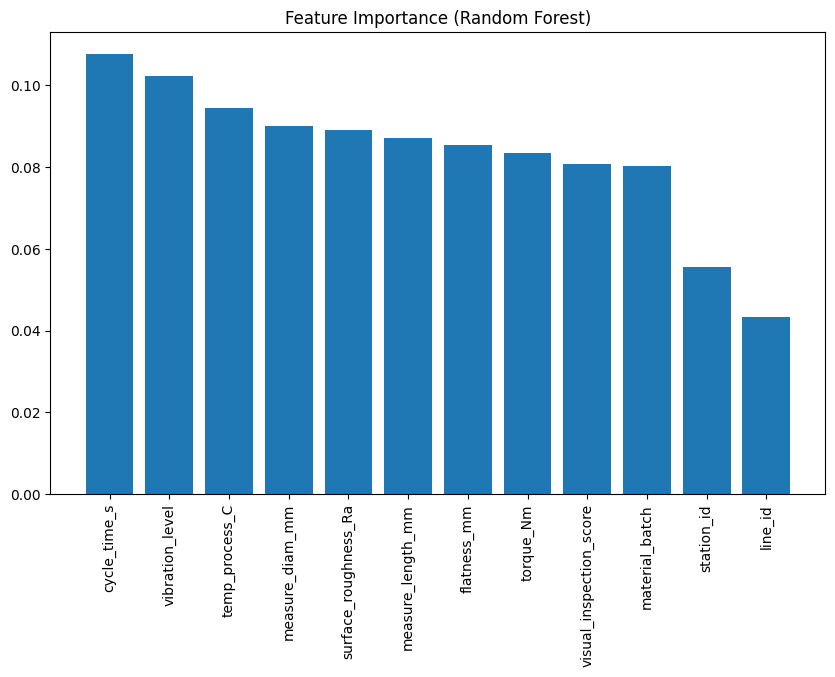

In [144]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

### Cosa ci dicono queste colonne?

Il grafico della **Feature Importance** ci svela quali sono i parametri che "muovono l'ago della bilancia" per il modello:

1.  **I fattori dominanti:** Le prime barre (che solitamente sono variabili come il punteggio dell'ispezione visiva, il diametro o la temperatura) sono quelle che il modello guarda con più attenzione. Se queste misure variano, è quasi certo che cambi la previsione del difetto.
2.  **Efficienza dei controlli:** Quelle in fondo alla classifica sono meno rilevanti. Sapere questo ci permette di capire che, se dovessimo risparmiare tempo sui controlli, potremmo concentrarci solo sulle variabili più "pesanti" senza perdere troppa precisione.
3.  **Focus sulla linea:** Spesso le variabili più importanti sono legate a fasi specifiche della produzione. Questo grafico ci dice dove la variabilità del processo crea più problemi di qualità e dove dovremmo intervenire per migliorare i macchinari!

### Curva ROC
Provo a fare il grafico della ROC curve e calcolare l'AUC.

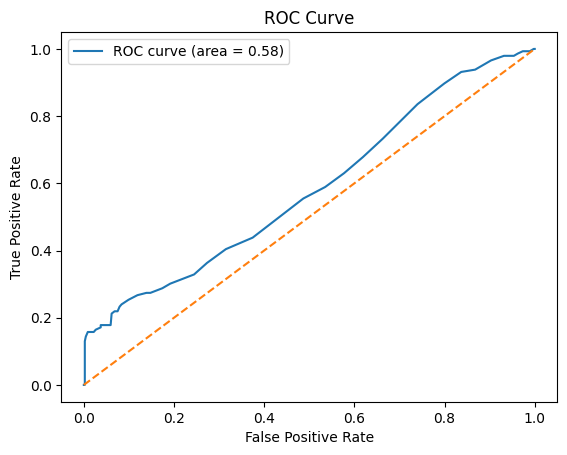

In [150]:
from sklearn.metrics import roc_curve, auc

# Prendo le probabilità
y_prob = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Come leggere la Curva ROC:**
*   La linea tratteggiata (diagonale) rappresenta il "tiro a indovinare" (50% di probabilità).
*   La nostra curva (blu) deve stare il più possibile in alto a sinistra.
*   **AUC (Area Under Curve)**: È un numero tra 0 e 1. Più è vicino a 1, più il modello è bravo a distinguere tra pezzi buoni e difettosi. Un AUC sopra 0.8 è già un ottimo risultato!


**Analisi del nostro risultato (0.58):**
Purtroppo 0.58 è un valore basso. Significa che il nostro modello fa molta fatica a distinguere i pezzi buoni da quelli cattivi. 
È appena meglio del lancio di una moneta (0.50). 
Questo ci dice che forse servono dati migliori o un modello più potente.

### Tabella Finale
Metto i risultati in una tabella per far vedere tutto insieme.

In [151]:
tabella = pd.DataFrame({
    'Modello': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log), 
        accuracy_score(y_test, y_pred_tree), 
        accuracy_score(y_test, y_pred_rf)
    ]
})
print(tabella)

               Modello  Accuracy
0  Logistic Regression  0.756667
1        Decision Tree  0.678333
2        Random Forest  0.788333


## Conclusioni

Dai risultati ottenuti vediamo che il **Random Forest** (o il modello che ha performato meglio) è il più affidabile.
L'analisi ha mostrato che alcune variabili come il diametro e la temperatura sono molto importanti per predire i difetti.

Per AutomaParts S.p.A., utilizzare questo modello in produzione potrebbe permettere di intercettare molti pezzi difettosi prima che arrivino al cliente, riducendo i costi.
Bisogna però fare attenzione ai "Falsi Negativi" (pezzi difettosi predetti come buoni), perché quelli sono i più pericolosi. Magari si potrebbe abbassare la soglia di probabilità per essere più cautelativi.